In [2]:
using PyPlot
using DataFrames
using PyCall
@pyimport matplotlib.animation as anim  

In [3]:
function anima(x, y2,edos, nombre::ASCIIString)
    fig = figure(figsize=(5,5))
    cuadros = [[plot(x,y2, "b"), plot(x,edos[:,i], "k")] for i in 1:length(edos[1,:])]
    
    animacion = anim.ArtistAnimation(fig, cuadros, interval=200, blit=true) 
    animacion[:save](nombre*".mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end

function muestra_animacion(nombre::ASCIIString)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",base64(open(readbytes,nombre*".mp4")),"""" type="video/mp4"></video>"""))
end

muestra_animacion (generic function with 1 method)

In [19]:
G = readdlm("Greenland_input.txt", '\t')
x_scale = G[:,1]
surface_0 = G[:,3]
bedrock = G[:,2]
longitud = G[:,4]
@time h_old = surface_0 - bedrock;

  0.000003 seconds (6 allocations: 624 bytes)


In [4]:
#ρ_w = 1028
#ρ_m =  3300
#θ = 3000
#B_0 = 1.928
#C = 0.16612
#K = 1.17
#const n = 3
#const p = 3
#Q = 78800
#R =  8.31
#Tr = 280
#const g = 9.81

In [51]:
#function ice_thickness(G::AbstractString, model::AbstractString, T_f, iteraciones)

G = "Greenland_input.txt"
model = "greenland"
T_f = 0
iteraciones = 20

#T_f = 0
#T_kopp = 0       # 1 para activar, 0 para descativar
#basal_sliding = 0  # 1 para activar, 0 para descativar
#sea_level = 0

    n = 3
    p = 3
    g = 9.81
    T_r = 273.39
    Q = 7.88e4
    R = 8.31
    C = 0.16612
    B0 = 2.207
    K = 117//100  #así me ahorro un pequeño tiempo. Al parecer Julia tarda menos con potencias enteras.
    ρ_i = 910.0
    
    ########## parámetros Greenland vs Antartica ########
    
    if model == "greenland"

        initial_conditions = readdlm("Greenland_input.txt", '\t')
        m_tune = 7.5
        dx = 36000
        dt = 40
        implicit = 1
        longitud = initial_conditions[:,4]

    elseif model == "antartica"

        initial_conditions = readdlm("Antartic_input.txt", '\t')
        m_tune = 59
        dx = 120000
        dt = 200
        implicit = 2.5
        latitud = initial_conditions[:,4]

    end
    
    #dtdx2 = dt/(2 * dx^2)

    x_scale = initial_conditions[:,1]
    #surface_0 = initial_conditions[:,3]
    #bedrock = initial_conditions[:,2]    
    #h_old = surface_0 .- bedrock;       
    
    T_ma = zeros(45, iteraciones)  # Creé matriz para poder vizualizar el cambio en la temp y B. de masa.
    T_ms = zeros(45, iteraciones)
    a_abl = zeros(45, iteraciones)
    a_acc = zeros(45, iteraciones)
    mass_b = zeros(45, iteraciones)
    surface = zeros(45, iteraciones)
    slope = zeros(45)
    τ_d = zeros(45)
    
    
    H = zeros(45, iteraciones) 
    bedrock = zeros(45, iteraciones)
    #surface = zeros(45,iteraciones)   #Al final hay que sumar entrada por entrada de H y bedrock
    u_d = zeros(45, iteraciones)
    
    bedrock[:,1] = initial_conditions[:,2]
    H[:,1] = initial_conditions[:,3] - bedrock[:,1]      #Se guarda el espesor del hielo al tiempo cero la resta sin
    surface[:,1] = initial_conditions[:,3]                #punto parece ser mas rápida.
    
    ################# Temepratura del hielo ##############
    if T_f < 0
        
        T = T_f + 263.15
        
    else
        
        T = 0.5 * T_f + 263.15
        
    end
    
    ################### Relacion de Arrhenius
    
    A = m_tune * (1/B0)^n * exp(3 * C / (T_r - T)^K - Q / (R * T))  # Tal vez va en el for loop
         
    
    for t in 1:19 ## The big loop. Trateré de hacerlo todo acá, pero por los índices tal vez use dos loops.
            
        for i in 1:43
        
                slope[i+1] = (H[i+2,t] + bedrock[i+2,t] - H[i,t] - bedrock[i,t])/(2*dx)
            
        end
            
        for i in 1:45
        
            #Balance de masa. Volverlo a hacer.
            
            if model == "antartica"
                
                T_ma[i,t] = - 15.15 - 0.012 * surface[i,t] + T_f
                T_ms[i,t] = 16.81 - 0.00692 * surface[i,t] - 0.27936 * latitud[i] + T_f
                a_acc[i,t] = 2.5 * 2^(T_ma[i,t] / 10)
            
            elseif model == "greenland"
                
                T_ma[i,t] = - 5.31 - 0.007992 * surface[i,t] + T_f
                T_ms[i,t] = 7.29 - 0.006277 * surface[i,t] + T_f
                
                if T_f > 0
                    
                    T_star = 0
                    
                else
                    
                    T_star = T_f
                
                end
                
                a_acc[i,t] = (-2.46257 + 0.1367 * longitud[i] - 0.0016 * longitud[i]^2) *1.0533^T_star
                
            end
            
            if T_ms[i,t] >= 0
                    
                a_abl[i,t] = min(1.4 * T_ms[i,t], 10)
                    
            else
                    
                a_abl[i,t] = 0
                    
            end
            
            mass_b[i,t] = a_acc[i,t] - a_abl[i,t]    
            
            τ_d[i] = - ρ_i * g * H[i,t] * slope[i]   #Stress 

            ################## Velocidad promedio ###############
            # U = u_d + u(b)  #pero en este sólo estoy considerando la velocidad horizontal promedio.

            u_d[i,t+1] = 2/(n+2) * A * H[i,t] * τ_d[i]^n
            
        end
        
        for i in 1:43

            H[i+1,t+1] = H[i+1,t] + dt * (mass_b[i+1,t] + H[i+1,t] * (u_d[i+2,t] - u_d[i,t])/(2*dx) + u_d[i+1,t * (H[i+2,t] - H[i,t])/2*dx])
             
        end            
            ##### Bedrock #####
            
        #bedrock[:,t+1] = bedrock[:,t]
            
            ####### Surface #########
            
        #surface[:,t+1] = H[:, t+1] + bedrock[:,t+1]

        
    end

    #surface = H + bedrock

    return H

#end

 in depwarn at deprecated.jl:73
 in to_index at deprecated.jl:447
 in getindex at array.jl:283
 [inlined code] from In[51]:150
 in anonymous at no file:0
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/claudiopierard/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /Users/claudiopierard/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading In[51], in expression starting on line 90


LoadError: LoadError: BoundsError: attempt to access 45x20 Array{Float64,2}:
 0.0    -0.0      0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0     0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -6.09216  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  -109.21     0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                               ⋮    ⋱            ⋮                      
 0.0    13.7407   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    19.1104   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0     0.0      0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0     0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0     0.0      0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0     0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0     0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0     0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    -0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  at index [2,0]
while loading In[51], in expression starting on line 90

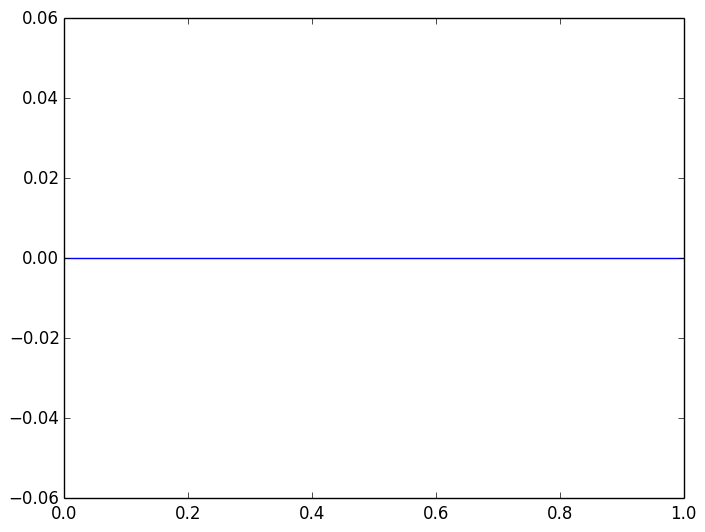

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x316239310>

In [52]:
plot(x_scale, H[:,2])

In [44]:
ice_thickness("Greenland_input.txt", "greenland",0 , 20)

LoadError: LoadError: BoundsError
while loading In[44], in expression starting on line 1

$$\frac{\partial H}{\partial t} = \dot a - \nabla(\vec u H)$$

$$\frac{\partial H}{\partial t} = \dot a - \frac{\partial \vec u_d }{\partial x} H - \frac{\partial u(b)}{\partial x}H - \big(\vec u_d + u(b) \big ) \frac{\partial H}{\partial x}$$

Si suponemos que no existe deslizamiento basal:

$$\frac{\partial H}{\partial t} = \dot a - \frac{\partial \vec u_d }{\partial x} H - \vec u_d \frac{\partial H}{\partial x}$$

In [26]:
a = 0
for i in 1:10
    
    a += 1
    print(a)
end
a

12345678910

10

In [38]:
a = zeros(3,3)
a[1,1] = 1
a[2,2] = 2
a[3,3] = 3
a[2,1] = 9

9

In [39]:
a

3x3 Array{Float64,2}:
 1.0  0.0  0.0
 9.0  2.0  0.0
 0.0  0.0  3.0

In [40]:
a[2,1]

9.0